In [10]:
# --- Imports ---
import os
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# --- Data Loader ---

BASE_DIR = "../data_file/data" # <-- change if your file is elsewhere

cancer_types = [
    "Breast Invasive Carcinoma",
    "Kidney Renal Clear Cell Carcinoma",
    "Lung Adenocarcinoma",
    "Lung Squamous Cell Carcinoma",
    "Pancreatic Adenocarcinoma",
    "Uveal Melanoma"
]

all_data = []
for cancer in cancer_types:
    cancer_dir = os.path.join(BASE_DIR, cancer)
    # Walk through files in the folder
    for root, _, files in os.walk(cancer_dir):
        for file in files:
            if file.endswith(".mirbase21.mirnas.quantification.txt"):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path, sep="\t")
                    # choose the columns we need
                df = df[["miRNA_ID", "reads_per_million_miRNA_mapped"]]
                    # add a new column for the cancer type
                df["cancer_type"] = cancer
                    # add the file ID to trace the files 
                df["file_id"] = os.path.basename(root)
                all_data.append(df)

# combine data
combined_df = pd.concat(all_data, ignore_index=True) 

# create CSV wide format
wide_df = combined_df.pivot_table(
    index=['file_id', 'cancer_type'], 
    columns='miRNA_ID', 
    values='reads_per_million_miRNA_mapped',
    fill_value=0 
).reset_index()

wide_df.to_csv("miRNA_wide_format.csv", index=False)
print("CSV sucessfully loaded!")

CSV sucessfully loaded!


In [14]:
df = pd.read_csv("miRNA_wide_format.csv")  # <-- change if your file is elsewhere
X = df.drop(columns=["file_id", "cancer_type"])  
y = df["cancer_type"] 
X = np.log1p(X) # log transformation

# train/test spilt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Classifier
model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# predict
y_pred = model.predict(X_test_scaled)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred)) 

Test Accuracy: 0.95

Classification Report:
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.96      0.99      0.98       219
Kidney Renal Clear Cell Carcinoma       1.00      0.94      0.97       109
              Lung Adenocarcinoma       0.96      0.90      0.93       104
     Lung Squamous Cell Carcinoma       0.87      0.97      0.92        96
        Pancreatic Adenocarcinoma       0.97      0.86      0.91        35
                   Uveal Melanoma       1.00      0.94      0.97        16

                         accuracy                           0.95       579
                        macro avg       0.96      0.93      0.94       579
                     weighted avg       0.95      0.95      0.95       579



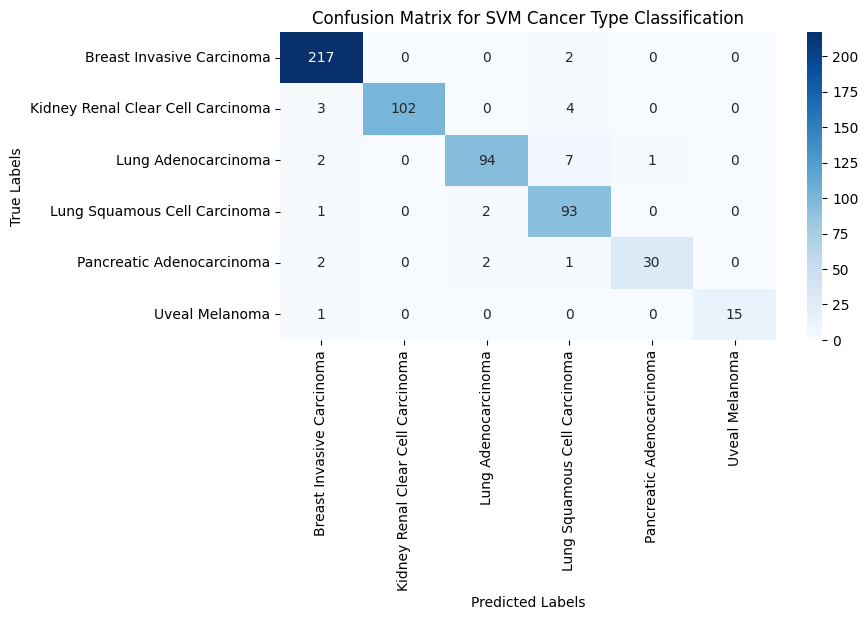

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for SVM Cancer Type Classification")
plt.show()